## Klasyfikator SVM

Stałe

In [282]:
SEED = 249919
SAMPLES = 100

Generowanie danych

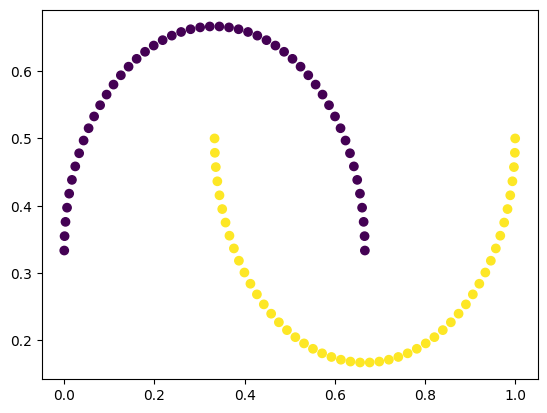

In [283]:
import numpy as np
from sklearn.datasets import make_moons, make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

X, y = make_moons(n_samples=SAMPLES, random_state=SEED)
X = NormalizeData(X)
y = NormalizeData(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

X_class, y_class = make_classification(n_samples=SAMPLES, n_classes=2, n_redundant = 0, n_informative = 2, n_features=2, random_state=SEED)
X_class = NormalizeData(X_class)
# y_class = NormalizeData(y_class)
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.2, random_state=SEED)

plt.scatter(X[:,0], X[:,1], label = "Data", c = y)
plt.show()


In [284]:
def make_meshgrid(x, y):
        x1 = np.linspace(-1.5 * x.min(), 1.5 * x.max(),300)
        x2 = np.linspace(-1.5 * y.min(), 1.5 * y.max(),300)
        xx, yy = np.meshgrid(x1,x2)
        return xx, yy

def show_plot(X, y, predicted, xx, yy):
    def plot_contours(ax, xx, yy):
        Z = predicted.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        return out

    fig, ax = plt.subplots()
    plot_contours(ax, xx, yy)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=15, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.legend()
    plt.show()

Implementacja scipy moons

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.95


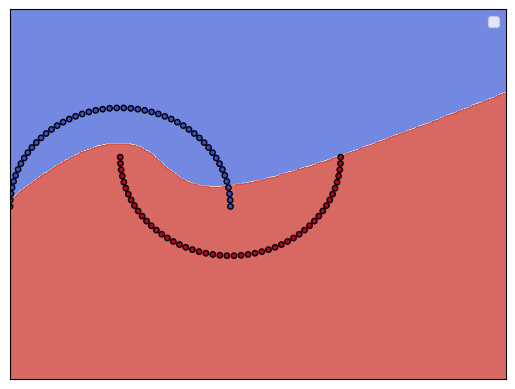

In [285]:
from sklearn.svm import SVC

def reward_function(y_true, y_pred):
    return 1 if y_true == y_pred else 0

xx, yy = make_meshgrid(X[:, 0], X[:, 1])
svm = SVC(kernel='poly')
clf = svm.fit(X, y)

rewards = []
for i in range(len(X_test)):
    pred = svm.predict([X_test[i]])
    rewards.append(reward_function(y_test[i], pred[0]))

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()])
accuracy = sum(rewards) / len(rewards)
print("Accuracy:", accuracy)
show_plot(X, y, predicted,xx,yy)

Implementacja scipy classification

Accuracy:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 1.0


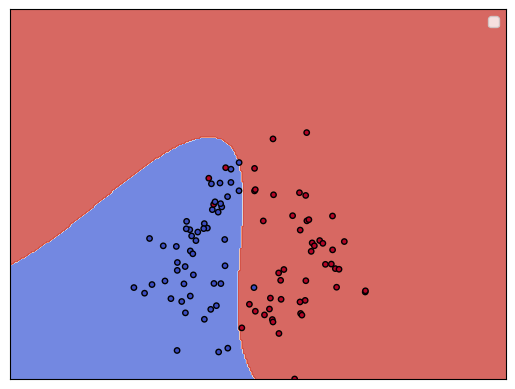

In [286]:
def reward_function(y_true, y_pred):
    return 1 if y_true == y_pred else 0

xx, yy = make_meshgrid(X_class[:, 0], X_class[:, 1])
svm = SVC(kernel='poly')
clf = svm.fit(X_class, y_class)

rewards = []
for i in range(len(X_class_test)):
    pred = svm.predict([X_class_test[i]])
    rewards.append(reward_function(y_class_test[i], pred[0]))

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()])
accuracy = sum(rewards) / len(rewards)
print("Accuracy:", accuracy)
show_plot(X_class, y_class, predicted, xx, yy)

Implementacja numeryczna

In [287]:
from typing import Any
from scipy.optimize import minimize, LinearConstraint
from scipy.spatial import distance_matrix
import numpy.random as rng
import math

class Kernel:
    def __init__(self) -> None:
        pass
    
    def __call__(self, A: np.ndarray, B: np.ndarray) -> Any:
        raise NotImplemented
    
class LinearKernel(Kernel):
    def __init__(self) -> None:
        super().__init__()

    def __call__(self, A: np.ndarray, B: np.ndarray) -> np.ndarray[Any, np.dtype[bool]]:
        return A.T @ B
    
class SquareKernel(Kernel):
    def __init__(self) -> None:
        super().__init__()

    def __call__(self, A: np.ndarray, B: np.ndarray) -> np.ndarray[Any, np.dtype[np.signedinteger[Any]]]:
        return (1 + A.T @ B) * (1 + A.T @ B)

class PolyKernel(Kernel):
    def __init__(self, degree) -> None:
        super().__init__()
        self._degree = degree

    def __call__(self, A: np.ndarray, B: np.ndarray) -> np.ndarray[Any, np.dtype[np.signedinteger[Any]]]:
        return np.power(1 + A.T @ B, self._degree)
    
class RadialKernel(Kernel):
    def __init__(self, gamma: float) -> None:
        super().__init__()
        self._gamma = gamma

    def __call__(self, A: np.ndarray, B: np.ndarray):
        return np.exp(-self._gamma * np.power(distance_matrix(A.T, B.T), 2))
    
class SigmoidKernel(Kernel):
    def __init__(self, alpha, C) -> None:
        super().__init__()
        self._alpha = alpha
        self._C = C

    def __call__(self, A: np.ndarray, B: np.ndarray):
        return np.tanh(self._alpha * A.T @ B + self._C)

class SVM:
    def __init__(self, kernel: Kernel, C: float = np.inf) -> None:
        self._kernel: Kernel = kernel
        self.C: float = C
        self._lambdas = None
        self._suppX = None
        self._suppY = None

    def transform(self, X: np.ndarray) -> Any:
        if self._lambdas is None:
            raise ValueError
        return np.sum(self._lambdas * self._suppY * self._kernel(X.T, self._suppX.T), axis=-1)

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        def svm_loss(lambdas: np.ndarray, X: np.ndarray, y: np.ndarray, kernel: Kernel) -> Any:
            y = y[:, np.newaxis]
            lambdas = lambdas[:, np.newaxis]
            loss = np.sum(lambdas) - 0.5 * np.sum((lambdas @ lambdas.T) * (y @ y.T) * kernel(X.T, X.T))
            return -loss
    
        self._lambdas = rng.random(y.shape) + 1e-3
        res: Any = minimize(
            svm_loss, 
            self._lambdas, 
            (X, y, self._kernel), 
            bounds = np.c_[np.zeros_like(self._lambdas), np.ones_like(self._lambdas) * self.C], 
            constraints = [LinearConstraint(y,0,0)],
            options={"maxiter": 1000, "disp":True}
        )
        mask = self._lambdas > 0
        self._lambdas = np.round(res.x, 3)
        self._lambdas = self._lambdas[mask]
        self._suppX = X[mask]
        self._suppY = y[mask]
        self._b = self._suppY - self.transform(self._suppX)
        self._b = sum(self._b) / len(self._b)
    
    def predict(self, X: np.ndarray) -> Any:
        return np.sign(self.transform(X) + self._b)

def eval_svm(
    kernel: Kernel,
    X: np.ndarray,
    y: np.ndarray,
    C: float = np.inf
) -> tuple[np.ndarray[Any, np.dtype[np.signedinteger[Any]]], Any, SVM]:
    y = 1 - 2 * y
    X_train = X
    X_test = X
    y_train = y
    y_test = y

    svm = SVM(kernel, C)
    svm.fit(X_train, y_train)
    return y_test, svm.predict(X_test), svm

def plot_classifier_from_model(model: SVM, X, y):
    x1 = np.linspace(1.5 * X[:, 0].min(), 1.5 * X[:,0].max(),300)
    x2 = np.linspace(1.5 * X[:, 1].min(), 1.5 * X[:,1].max(),300)
    xx, yy = np.meshgrid(x1,x2)
    XX = np.stack((xx.flatten(), yy.flatten())).T
    zz = model.predict(XX)
    zz = zz.reshape(xx.shape)

    plt.figure(figsize=(10,10))
    # plt.contourf(xx,yy,(1-zz)//2,cmap=plt.cm.coolwarm, alpha=0.8)
    # plt.scatter(X[:, 0], X[:, 1], c=y)
    # plt.scatter(model._suppX[:, 0],model._suppX[:, 1], c=model._suppY < 0, cmap=plt.cm.coolwarm, edgecolors='red')
    plt.contourf(xx,yy,zz,alpha=0.5)
    plt.legend()
    plt.show()

Predykcja Moons

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10807101.985376218
            Iterations: 225
            Function evaluations: 24389
            Gradient evaluations: 221


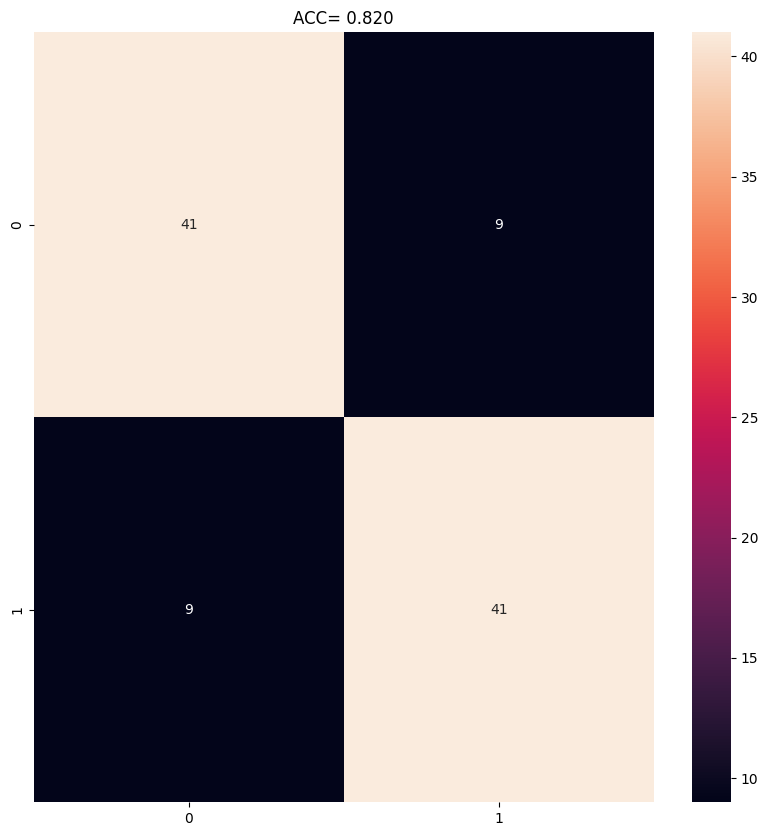

In [288]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import seaborn as sns

y_true, y_pred, model = eval_svm(LinearKernel(), X, y)

acc = balanced_accuracy_score(y_true, y_pred)
conf = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(conf, annot=True, fmt="d")
plt.title(f"ACC={acc: .3f}")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


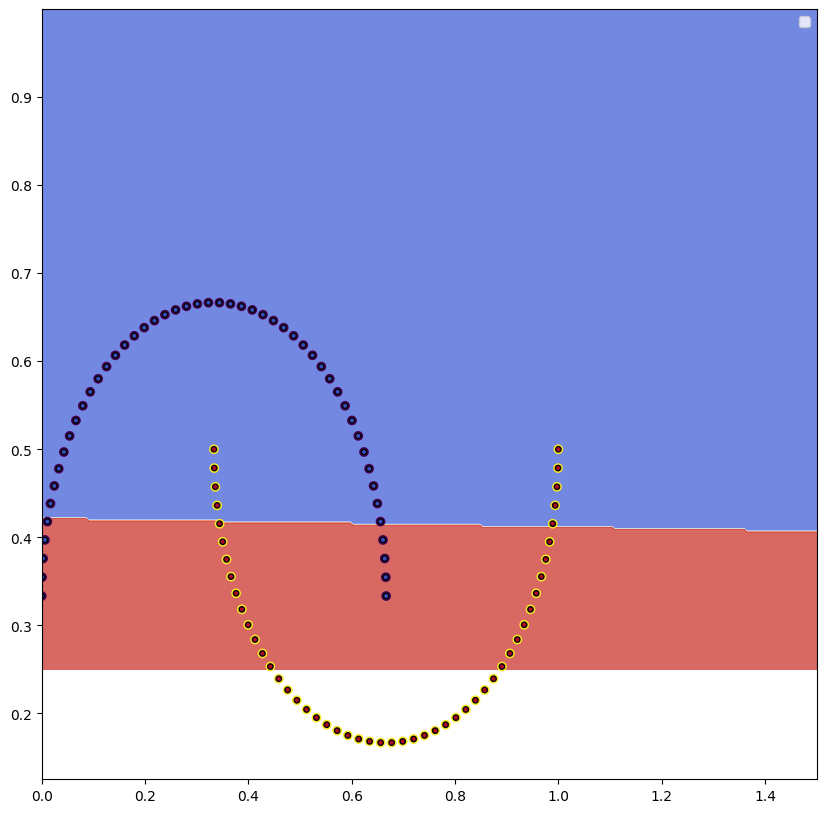

In [289]:

plot_classifier_from_model(model,X,y)

Predykcja Class

Optimization terminated successfully    (Exit mode 0)
            Current function value: -279779.01519626356
            Iterations: 271
            Function evaluations: 29732
            Gradient evaluations: 270


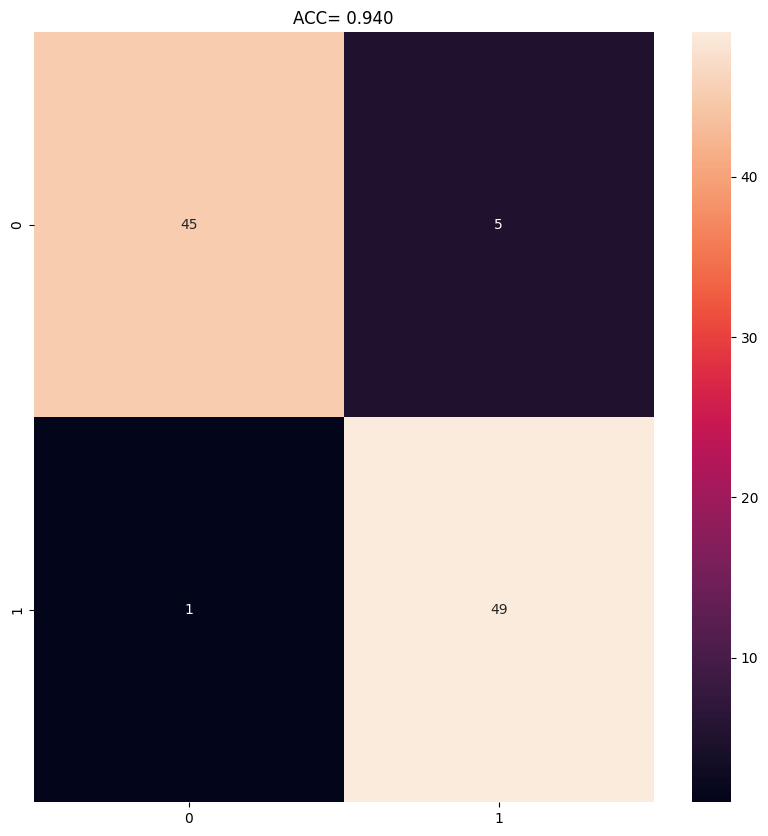

In [290]:
y_true, y_pred, model = eval_svm(LinearKernel(), X_class, y_class)

acc = balanced_accuracy_score(y_true, y_pred)
conf = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(conf, annot=True, fmt="d")
plt.title(f"ACC={acc: .3f}")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


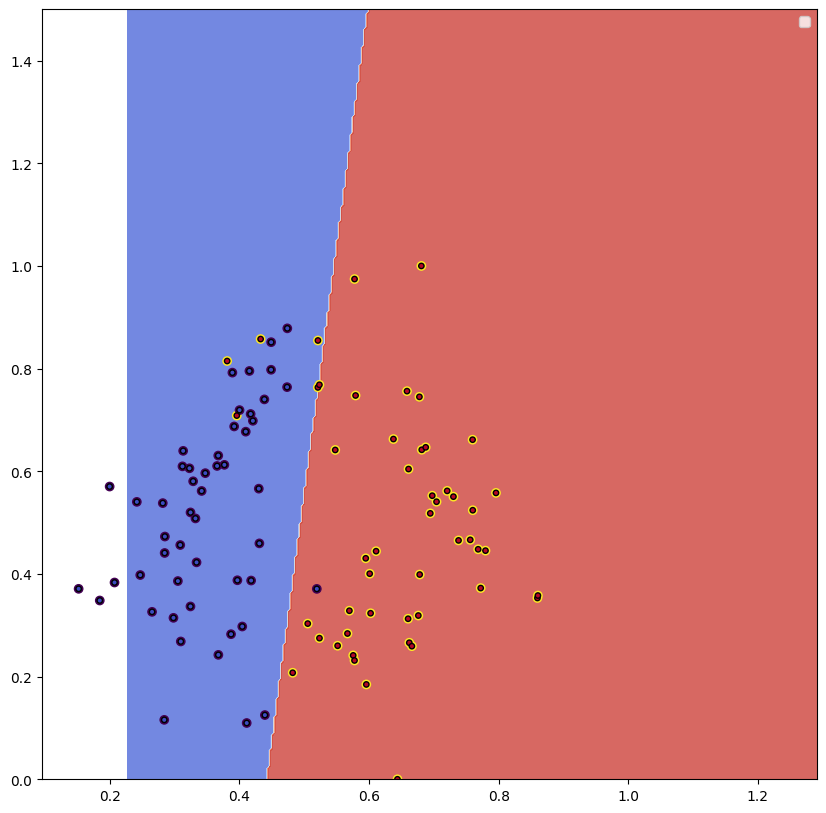

In [291]:
plot_classifier_from_model(model,X_class, y_class)